[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Transcribing with both models:   0%|                                                            | 0/39 [00:00<?, ?it/s]`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 27007, 30109, 30420, 33409, 34949, 40283, 40493, 40549, 47282, 49146, 50257, 50357, 50358, 50359, 50360, 50361], 'begin_suppress_tokens': [220, 50256]}. If this is not desired, please set these values explici

Comparison saved to comparisonBaseModelDatasetA_1_2.csv
Wrong word distributions saved.

Baseline Whisper Avg Accuracy: 57.31%
Fine-Tuned Whisper Avg Accuracy: 65.21%


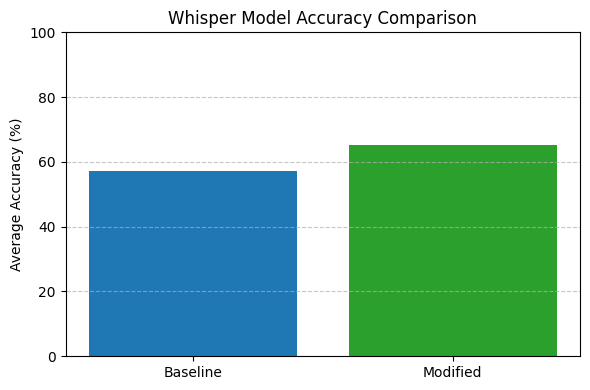

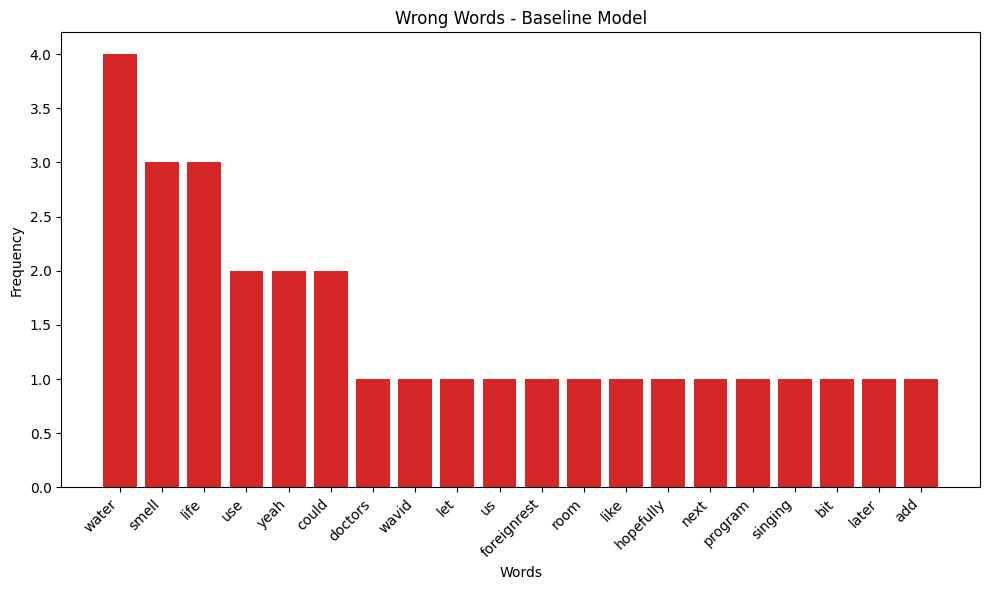

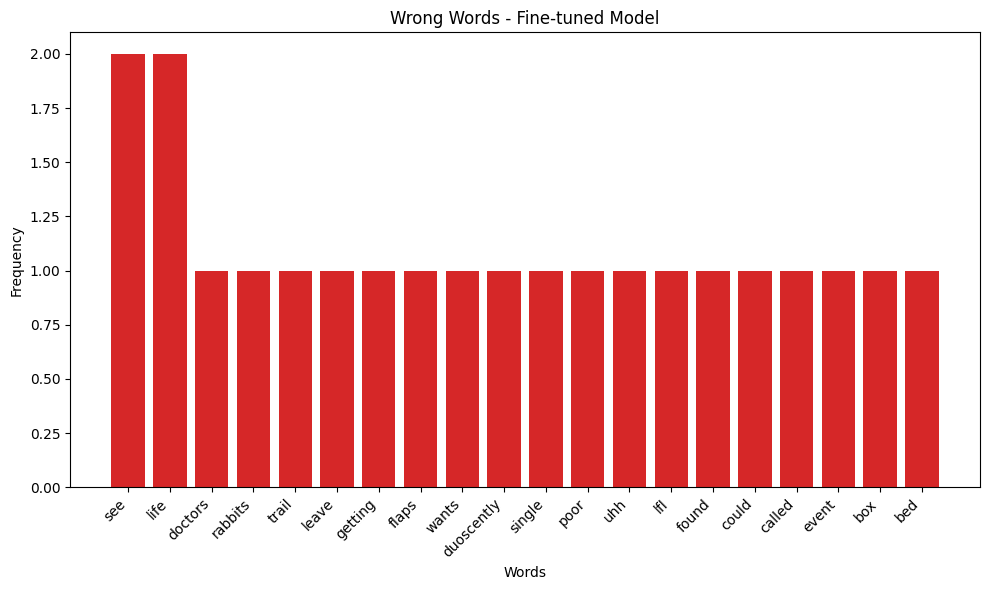

In [1]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import difflib

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Jiwer transformations
transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

# Load fine-tuned model
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def custom_transcribe(audio_path):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)
    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

def remove_stopwords_from_lists(token_lists):
    return [[word for word in token_list if word not in stop_words] for token_list in token_lists]

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def get_wrong_words(truth, hypothesis):
    wrong_words = []
    matcher = difflib.SequenceMatcher(None, truth, hypothesis)
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != "equal":
            for word in hypothesis[j1:j2]:
                if word not in stop_words:
                    wrong_words.append(word)
    return wrong_words

def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []
    baseline_wrong_words = Counter()
    modified_wrong_words = Counter()

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]

        # Fine-tuned transcription
        try:
            modified_text = custom_transcribe(file_path)
        except Exception as e:
            print(f"Error processing {filename} with fine-tuned model: {e}")
            modified_text = ""

        # Apply transformations and remove stopwords
        truth_transformed = transforms(ground_truth)
        base_transformed = transforms(base_text)
        mod_transformed = transforms(modified_text)

        truth_nostop = remove_stopwords_from_lists(truth_transformed)
        base_nostop = remove_stopwords_from_lists(base_transformed)
        mod_nostop = remove_stopwords_from_lists(mod_transformed)

        # Skip if ground truth is empty after stopword removal
        if not truth_nostop or not truth_nostop[0]:
            print(f"Skipping {filename} due to empty ground truth after stopword removal.")
            continue

        # WER computation
        base_error = jiwer.wer(' '.join(flatten(truth_nostop)), ' '.join(flatten(base_nostop)), truth_transform=transforms, hypothesis_transform=transforms)
        mod_error = jiwer.wer(' '.join(flatten(truth_nostop)), ' '.join(flatten(mod_nostop)), truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100, 0)
        mod_accuracy = max((1 - mod_error) * 100, 0)

        base_wrong = get_wrong_words(truth_transformed[0], base_transformed[0])
        mod_wrong = get_wrong_words(truth_transformed[0], mod_transformed[0])

        baseline_wrong_words.update(base_wrong)
        modified_wrong_words.update(mod_wrong)

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results, baseline_wrong_words, modified_wrong_words

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetA_1_2.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

def save_wrong_word_distribution(counter, output_file):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Wrong Word", "Count"])
        for word, count in counter.most_common():
            writer.writerow([word, count])

def plot_top_wrong_words(counter, title, filename):
    words, counts = zip(*counter.most_common(20)) if counter else ([], [])
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color="#d62728")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Run
audio_dir = "dataset/a/"
baseline_results, modified_results, baseline_wrong_words, modified_wrong_words = transcribe_with_both_models(audio_dir)

# Save results
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetA_1_2.csv")

save_wrong_word_distribution(baseline_wrong_words, "baseline_wrong_words_a_1.csv")
save_wrong_word_distribution(modified_wrong_words, "modified_wrong_words_a_1.csv")
print("Wrong word distributions saved.")

# Print and plot average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)

print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()

# Plot wrong words
plot_top_wrong_words(baseline_wrong_words, "Wrong Words - Baseline Model", "baseline_wrong_words_a_1.png")
plot_top_wrong_words(modified_wrong_words, "Wrong Words - Fine-tuned Model", "modified_wrong_words_a_1.png")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Transcribing with both models:  22%|███████████                                        | 11/51 [01:00<03:37,  5.43s/it]

Skipping 276.897_277.257.mp3 due to empty ground truth after stopword removal.


Transcribing with both models:  88%|█████████████████████████████████████████████      | 45/51 [07:08<01:09, 11.52s/it]

Skipping 774.559_774.599.mp3 due to empty ground truth after stopword removal.


Transcribing with both models: 100%|███████████████████████████████████████████████████| 51/51 [08:05<00:00,  9.52s/it]

Skipping 96.104_96.644.mp3 due to empty ground truth after stopword removal.
Comparison saved to comparisonBaseModelDatasetB_1_2.csv
Wrong word distributions saved.

Baseline Whisper Avg Accuracy: 51.60%
Fine-Tuned Whisper Avg Accuracy: 69.67%


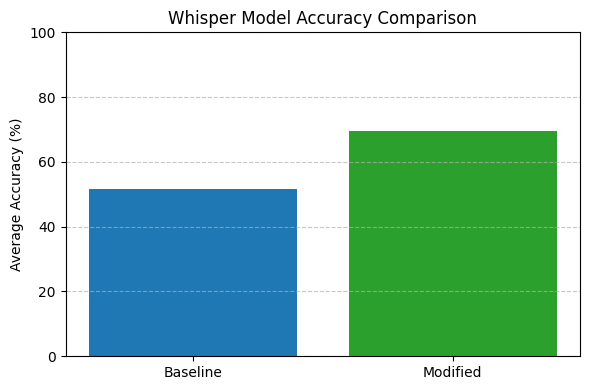

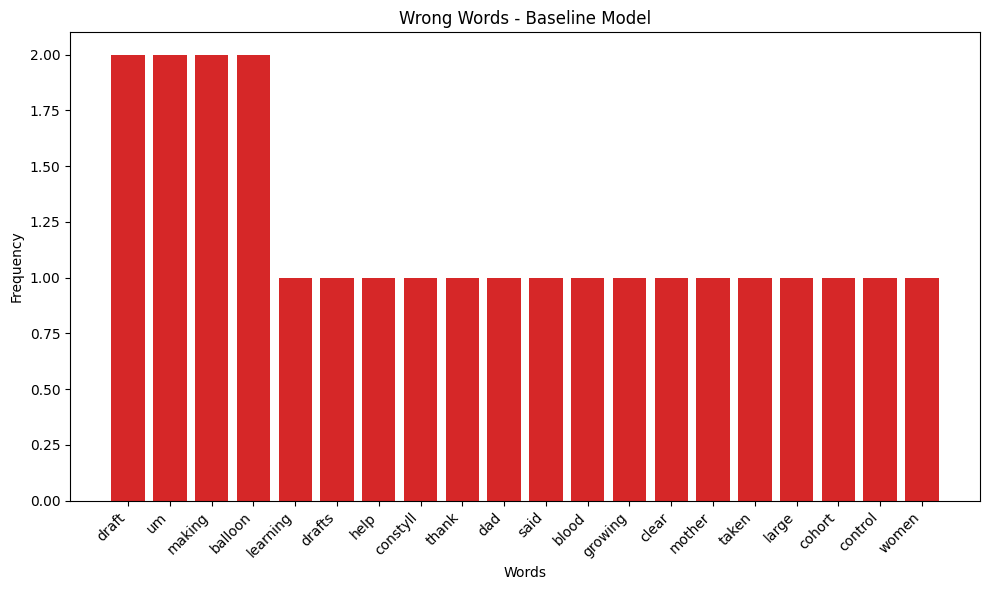

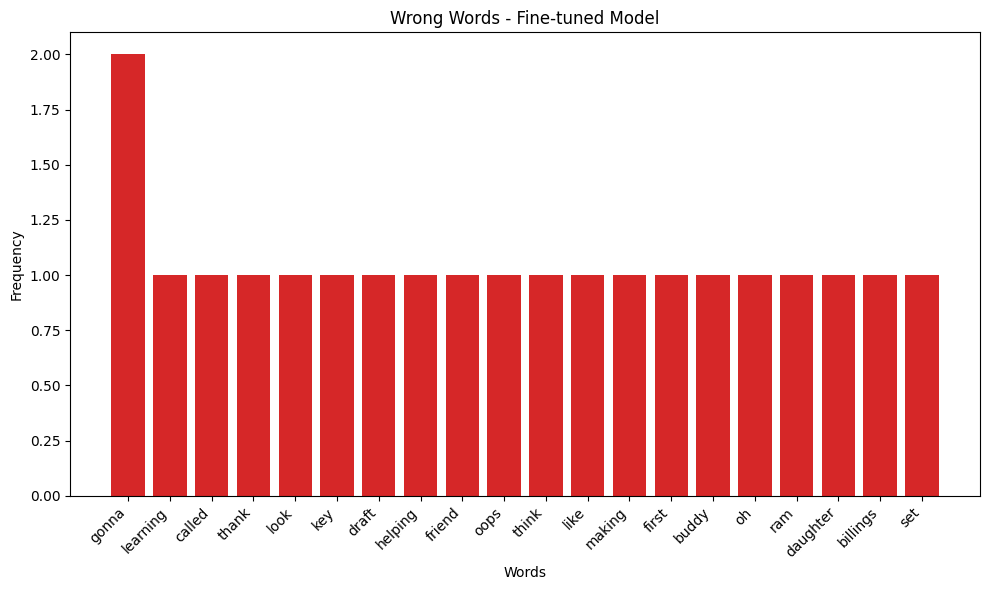

In [2]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import difflib

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Jiwer transformations
transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

# Load fine-tuned model
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def custom_transcribe(audio_path):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)
    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

def remove_stopwords_from_lists(token_lists):
    return [[word for word in token_list if word not in stop_words] for token_list in token_lists]

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def get_wrong_words(truth, hypothesis):
    wrong_words = []
    matcher = difflib.SequenceMatcher(None, truth, hypothesis)
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != "equal":
            for word in hypothesis[j1:j2]:
                if word not in stop_words:
                    wrong_words.append(word)
    return wrong_words

def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []
    baseline_wrong_words = Counter()
    modified_wrong_words = Counter()

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]

        # Fine-tuned transcription
        try:
            modified_text = custom_transcribe(file_path)
        except Exception as e:
            print(f"Error processing {filename} with fine-tuned model: {e}")
            modified_text = ""

        # Apply transformations and remove stopwords
        truth_transformed = transforms(ground_truth)
        base_transformed = transforms(base_text)
        mod_transformed = transforms(modified_text)

        truth_nostop = remove_stopwords_from_lists(truth_transformed)
        base_nostop = remove_stopwords_from_lists(base_transformed)
        mod_nostop = remove_stopwords_from_lists(mod_transformed)

        # Skip if ground truth is empty after stopword removal
        if not truth_nostop or not truth_nostop[0]:
            print(f"Skipping {filename} due to empty ground truth after stopword removal.")
            continue

        # WER computation
        base_error = jiwer.wer(' '.join(flatten(truth_nostop)), ' '.join(flatten(base_nostop)), truth_transform=transforms, hypothesis_transform=transforms)
        mod_error = jiwer.wer(' '.join(flatten(truth_nostop)), ' '.join(flatten(mod_nostop)), truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100, 0)
        mod_accuracy = max((1 - mod_error) * 100, 0)

        base_wrong = get_wrong_words(truth_transformed[0], base_transformed[0])
        mod_wrong = get_wrong_words(truth_transformed[0], mod_transformed[0])

        baseline_wrong_words.update(base_wrong)
        modified_wrong_words.update(mod_wrong)

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results, baseline_wrong_words, modified_wrong_words

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetB_1_2.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

def save_wrong_word_distribution(counter, output_file):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Wrong Word", "Count"])
        for word, count in counter.most_common():
            writer.writerow([word, count])

def plot_top_wrong_words(counter, title, filename):
    words, counts = zip(*counter.most_common(20)) if counter else ([], [])
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color="#d62728")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Run
audio_dir = "dataset/b/"
baseline_results, modified_results, baseline_wrong_words, modified_wrong_words = transcribe_with_both_models(audio_dir)

# Save results
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetB_1_2.csv")

save_wrong_word_distribution(baseline_wrong_words, "baseline_wrong_words_b_1.csv")
save_wrong_word_distribution(modified_wrong_words, "modified_wrong_words_b_1.csv")
print("Wrong word distributions saved.")

# Print and plot average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)

print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()

# Plot wrong words
plot_top_wrong_words(baseline_wrong_words, "Wrong Words - Baseline Model", "baseline_wrong_words_b_1.png")
plot_top_wrong_words(modified_wrong_words, "Wrong Words - Fine-tuned Model", "modified_wrong_words_b_1.png")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Transcribing with both models: 100%|███████████████████████████████████████████████████| 32/32 [06:24<00:00, 12.02s/it]


Comparison saved to comparisonBaseModelDatasetC_1_2.csv
Wrong word distributions saved.

Baseline Whisper Avg Accuracy: 42.55%
Fine-Tuned Whisper Avg Accuracy: 65.00%


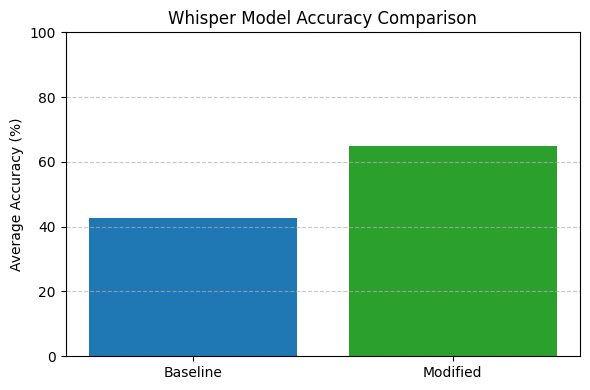

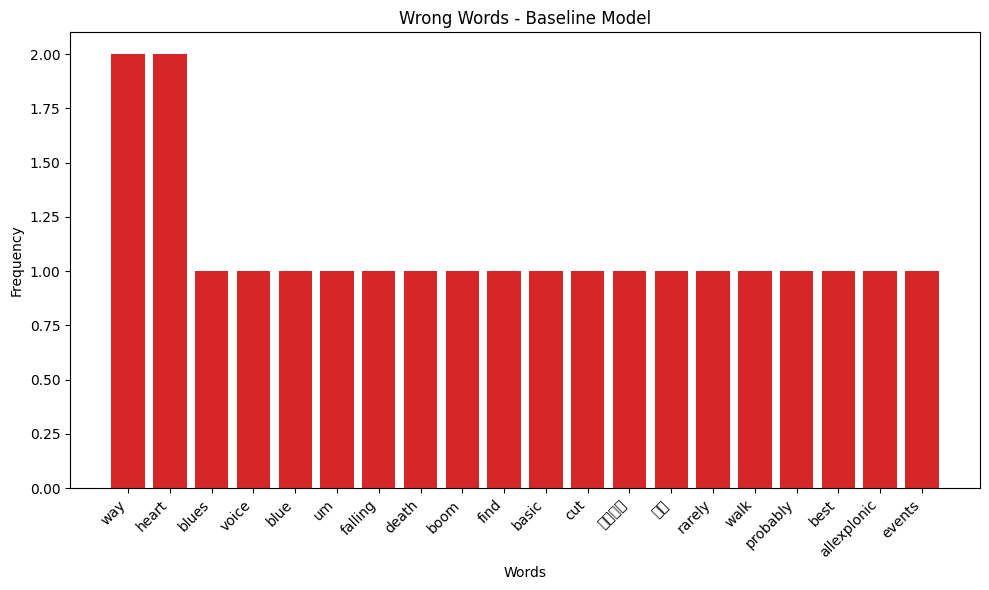

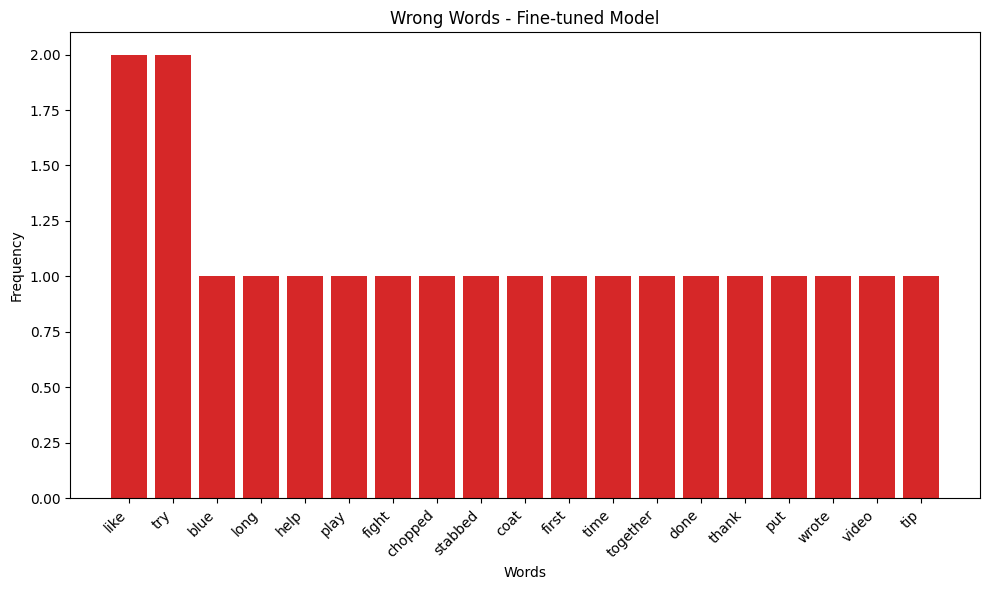

In [3]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import difflib

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Jiwer transformations
transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

# Load fine-tuned model
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def custom_transcribe(audio_path):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)
    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

def remove_stopwords_from_lists(token_lists):
    return [[word for word in token_list if word not in stop_words] for token_list in token_lists]

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def get_wrong_words(truth, hypothesis):
    wrong_words = []
    matcher = difflib.SequenceMatcher(None, truth, hypothesis)
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != "equal":
            for word in hypothesis[j1:j2]:
                if word not in stop_words:
                    wrong_words.append(word)
    return wrong_words

def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []
    baseline_wrong_words = Counter()
    modified_wrong_words = Counter()

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]

        # Fine-tuned transcription
        try:
            modified_text = custom_transcribe(file_path)
        except Exception as e:
            print(f"Error processing {filename} with fine-tuned model: {e}")
            modified_text = ""

        # Apply transformations and remove stopwords
        truth_transformed = transforms(ground_truth)
        base_transformed = transforms(base_text)
        mod_transformed = transforms(modified_text)

        truth_nostop = remove_stopwords_from_lists(truth_transformed)
        base_nostop = remove_stopwords_from_lists(base_transformed)
        mod_nostop = remove_stopwords_from_lists(mod_transformed)

        # Skip if ground truth is empty after stopword removal
        if not truth_nostop or not truth_nostop[0]:
            print(f"Skipping {filename} due to empty ground truth after stopword removal.")
            continue

        # WER computation
        base_error = jiwer.wer(' '.join(flatten(truth_nostop)), ' '.join(flatten(base_nostop)), truth_transform=transforms, hypothesis_transform=transforms)
        mod_error = jiwer.wer(' '.join(flatten(truth_nostop)), ' '.join(flatten(mod_nostop)), truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100, 0)
        mod_accuracy = max((1 - mod_error) * 100, 0)

        base_wrong = get_wrong_words(truth_transformed[0], base_transformed[0])
        mod_wrong = get_wrong_words(truth_transformed[0], mod_transformed[0])

        baseline_wrong_words.update(base_wrong)
        modified_wrong_words.update(mod_wrong)

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results, baseline_wrong_words, modified_wrong_words

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetC_1_2.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

def save_wrong_word_distribution(counter, output_file):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Wrong Word", "Count"])
        for word, count in counter.most_common():
            writer.writerow([word, count])

def plot_top_wrong_words(counter, title, filename):
    words, counts = zip(*counter.most_common(20)) if counter else ([], [])
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color="#d62728")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Run
audio_dir = "dataset/c/"
baseline_results, modified_results, baseline_wrong_words, modified_wrong_words = transcribe_with_both_models(audio_dir)

# Save results
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetC_1_2.csv")

save_wrong_word_distribution(baseline_wrong_words, "baseline_wrong_words_c_1.csv")
save_wrong_word_distribution(modified_wrong_words, "modified_wrong_words_c_1.csv")
print("Wrong word distributions saved.")

# Print and plot average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)

print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()

# Plot wrong words
plot_top_wrong_words(baseline_wrong_words, "Wrong Words - Baseline Model", "baseline_wrong_words_c_1.png")
plot_top_wrong_words(modified_wrong_words, "Wrong Words - Fine-tuned Model", "modified_wrong_words_c_1.png")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Transcribing with both models: 100%|███████████████████████████████████████████████████| 66/66 [09:11<00:00,  8.36s/it]


Comparison saved to comparisonBaseModelDatasetD_1_2.csv
Wrong word distributions saved.

Baseline Whisper Avg Accuracy: 65.30%
Fine-Tuned Whisper Avg Accuracy: 73.97%


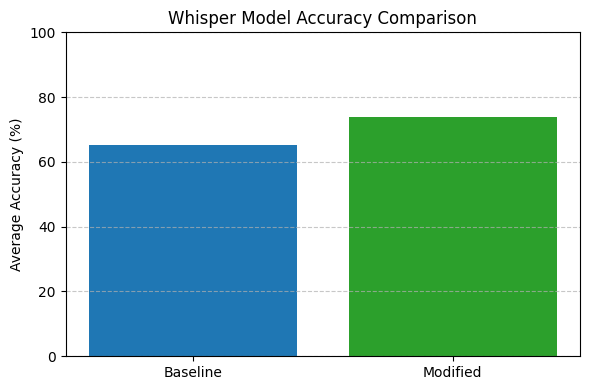

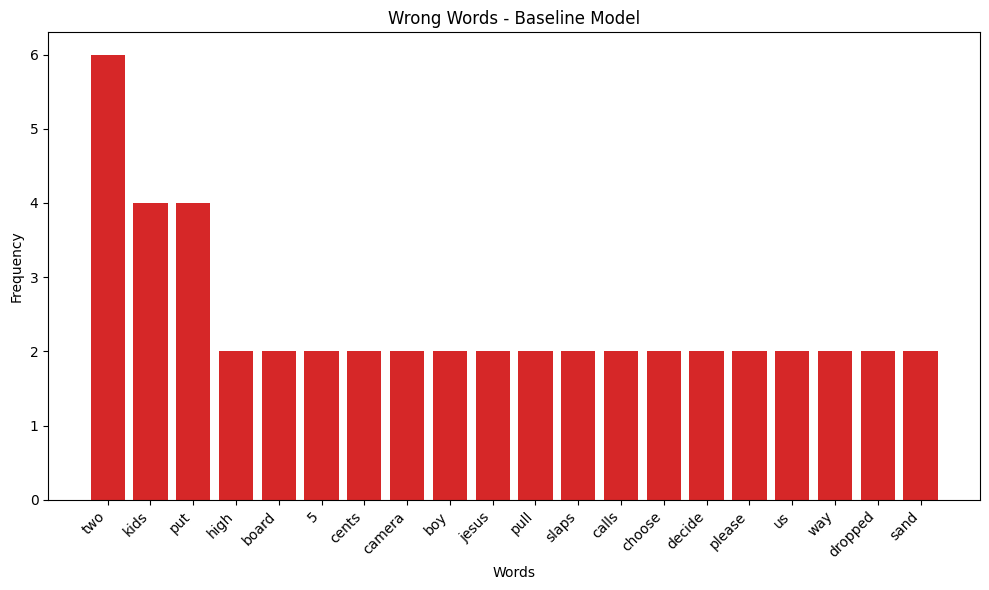

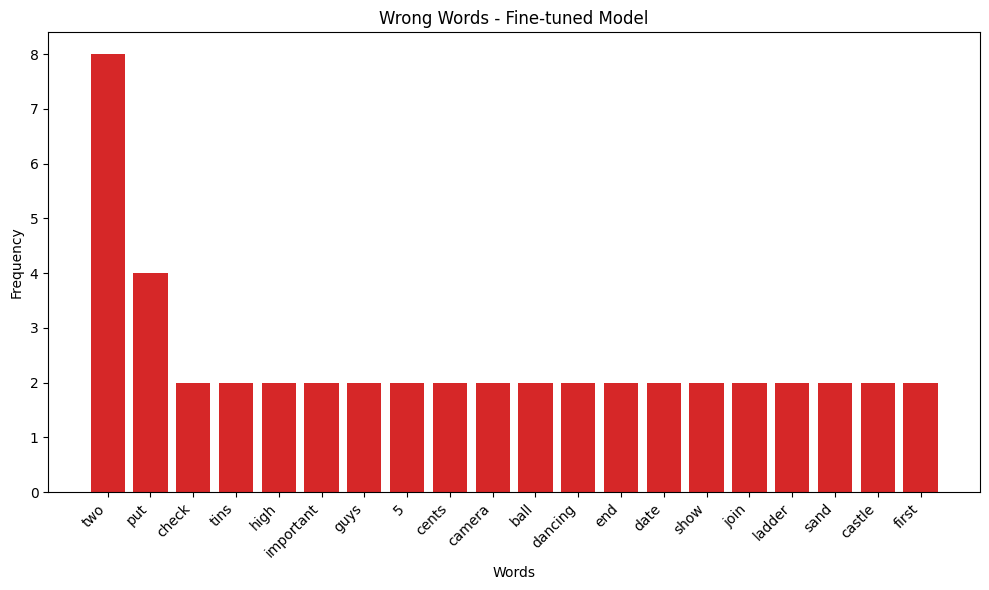

In [4]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import difflib

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Jiwer transformations
transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

# Load fine-tuned model
model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def custom_transcribe(audio_path):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()
    features = ft_processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features
    if hasattr(ft_model.generation_config, "forced_decoder_ids"):
        ft_model.generation_config.forced_decoder_ids = None
    with torch.no_grad():
        predicted_ids = ft_model.generate(input_features)
    transcription = ft_processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

def remove_stopwords_from_lists(token_lists):
    return [[word for word in token_list if word not in stop_words] for token_list in token_lists]

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def get_wrong_words(truth, hypothesis):
    wrong_words = []
    matcher = difflib.SequenceMatcher(None, truth, hypothesis)
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != "equal":
            for word in hypothesis[j1:j2]:
                if word not in stop_words:
                    wrong_words.append(word)
    return wrong_words

def transcribe_with_both_models(audio_dir):
    baseline_results = []
    modified_results = []
    baseline_wrong_words = Counter()
    modified_wrong_words = Counter()

    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]

    for filename in tqdm(files, desc="Transcribing with both models"):
        file_path = os.path.join(audio_dir, filename)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(audio_dir, txt_filename)

        ground_truth = ""
        if os.path.exists(txt_path):
            with open(txt_path, "r", encoding="utf-8") as gt_file:
                ground_truth = gt_file.read()

        # Baseline transcription
        base_model = whisper.load_model("base")
        base_result = base_model.transcribe(file_path)
        base_text = base_result["text"]

        # Fine-tuned transcription
        try:
            modified_text = custom_transcribe(file_path)
        except Exception as e:
            print(f"Error processing {filename} with fine-tuned model: {e}")
            modified_text = ""

        # Apply transformations and remove stopwords
        truth_transformed = transforms(ground_truth)
        base_transformed = transforms(base_text)
        mod_transformed = transforms(modified_text)

        truth_nostop = remove_stopwords_from_lists(truth_transformed)
        base_nostop = remove_stopwords_from_lists(base_transformed)
        mod_nostop = remove_stopwords_from_lists(mod_transformed)

        # Skip if ground truth is empty after stopword removal
        if not truth_nostop or not truth_nostop[0]:
            print(f"Skipping {filename} due to empty ground truth after stopword removal.")
            continue

        # WER computation
        base_error = jiwer.wer(' '.join(flatten(truth_nostop)), ' '.join(flatten(base_nostop)), truth_transform=transforms, hypothesis_transform=transforms)
        mod_error = jiwer.wer(' '.join(flatten(truth_nostop)), ' '.join(flatten(mod_nostop)), truth_transform=transforms, hypothesis_transform=transforms)
        base_accuracy = max((1 - base_error) * 100, 0)
        mod_accuracy = max((1 - mod_error) * 100, 0)

        base_wrong = get_wrong_words(truth_transformed[0], base_transformed[0])
        mod_wrong = get_wrong_words(truth_transformed[0], mod_transformed[0])

        baseline_wrong_words.update(base_wrong)
        modified_wrong_words.update(mod_wrong)

        baseline_results.append({
            "filename": filename,
            "transcription": base_text,
            "ground_truth": ground_truth,
            "accuracy": round(base_accuracy, 2)
        })

        modified_results.append({
            "filename": filename,
            "transcription": modified_text,
            "ground_truth": ground_truth,
            "accuracy": round(mod_accuracy, 2)
        })

    return baseline_results, modified_results, baseline_wrong_words, modified_wrong_words

def save_comparison_to_csv(baseline, modified, output_file="comparisonBaseModelDatasetD_1_2.csv"):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Baseline Accuracy (%)", "Modified Accuracy (%)", "Baseline Text", "Modified Text", "Ground Truth"])
        for b, m in zip(baseline, modified):
            writer.writerow([b["filename"], b["accuracy"], m["accuracy"], b["transcription"], m["transcription"], b["ground_truth"]])

def save_wrong_word_distribution(counter, output_file):
    with open(output_file, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Wrong Word", "Count"])
        for word, count in counter.most_common():
            writer.writerow([word, count])

def plot_top_wrong_words(counter, title, filename):
    words, counts = zip(*counter.most_common(20)) if counter else ([], [])
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color="#d62728")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Run
audio_dir = "dataset/d/"
baseline_results, modified_results, baseline_wrong_words, modified_wrong_words = transcribe_with_both_models(audio_dir)

# Save results
save_comparison_to_csv(baseline_results, modified_results)
print("Comparison saved to comparisonBaseModelDatasetD_1_2.csv")

save_wrong_word_distribution(baseline_wrong_words, "baseline_wrong_words_d_1.csv")
save_wrong_word_distribution(modified_wrong_words, "modified_wrong_words_d_1.csv")
print("Wrong word distributions saved.")

# Print and plot average accuracy
baseline_avg = sum([x["accuracy"] for x in baseline_results]) / len(baseline_results)
modified_avg = sum([x["accuracy"] for x in modified_results]) / len(modified_results)

print(f"\nBaseline Whisper Avg Accuracy: {baseline_avg:.2f}%")
print(f"Fine-Tuned Whisper Avg Accuracy: {modified_avg:.2f}%")

plt.figure(figsize=(6, 4))
plt.bar(["Baseline", "Modified"], [baseline_avg, modified_avg], color=["#1f77b4", "#2ca02c"])
plt.ylabel("Average Accuracy (%)")
plt.title("Whisper Model Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("whisper_accuracy_comparison.png")
plt.show()

# Plot wrong words
plot_top_wrong_words(baseline_wrong_words, "Wrong Words - Baseline Model", "baseline_wrong_words_d_1.png")
plot_top_wrong_words(modified_wrong_words, "Wrong Words - Fine-tuned Model", "modified_wrong_words_d_1.png")
